In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

detect_ai_vs_human_generated_images_path = kagglehub.competition_download('detect-ai-vs-human-generated-images')
alessandrasala79_ai_vs_human_generated_dataset_path = kagglehub.dataset_download('alessandrasala79/ai-vs-human-generated-dataset')

print('Data source import complete.')


100%|██████████| 1.89M/1.89M [00:00<00:00, 115MB/s]

Extracting files...


Data source import complete.


In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


In [ ]:
import pandas as pd
import os

image_dataset_path = "/kaggle/input/ai-vs-human-generated-dataset/"

train_df = pd.read_csv(image_dataset_path + "train.csv")

train_df["file_name"] = image_dataset_path + train_df["file_name"]


train_df.head()


,Unnamed: 0,file_name,label
0,0,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
1,1,/kaggle/input/ai-vs-human-generated-dataset/tr...,0
2,2,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
3,3,/kaggle/input/ai-vs-human-generated-dataset/tr...,0
4,4,/kaggle/input/ai-vs-human-generated-dataset/tr...,1


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79950 entries, 0 to 79949
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  79950 non-null  int64 
 1   file_name   79950 non-null  object
 2   label       79950 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.8+ MB


In [ ]:
train_df=train_df.drop('Unnamed: 0',axis=1)


In [ ]:
import os

missing_files = train_df[~train_df["file_name"].apply(os.path.exists)]
print(f"Missing train images: {len(missing_files)}")

Missing train images: 0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79950 entries, 0 to 79949
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  79950 non-null  object
 1   label      79950 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


In [ ]:
import random
from PIL import Image

ai_images = train_df[train_df["label"] == 1]["file_name"].tolist()
human_images = train_df[train_df["label"] == 0]["file_name"].tolist()

# Function to display images
def show_images(image_paths, title, num_images=5):
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(random.sample(image_paths, num_images)):
        img = Image.open(img_path)  # Open image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.show()


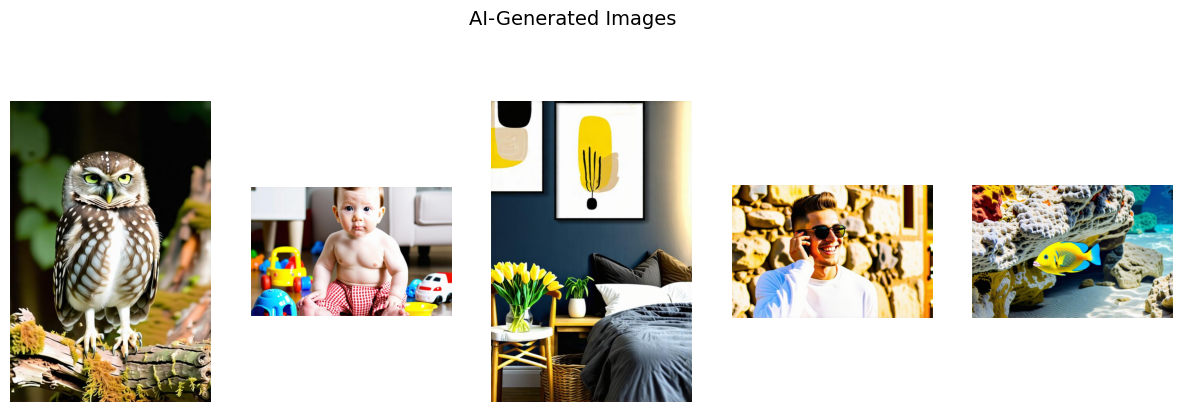

In [ ]:
show_images(ai_images, "AI-Generated Images")


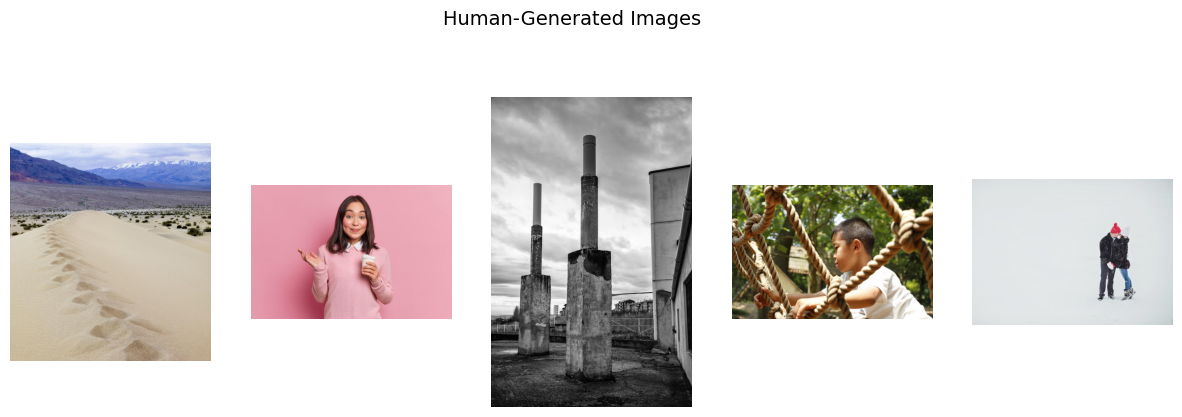

In [ ]:
show_images(human_images, "Human-Generated Images")


# Show Similar photos in both

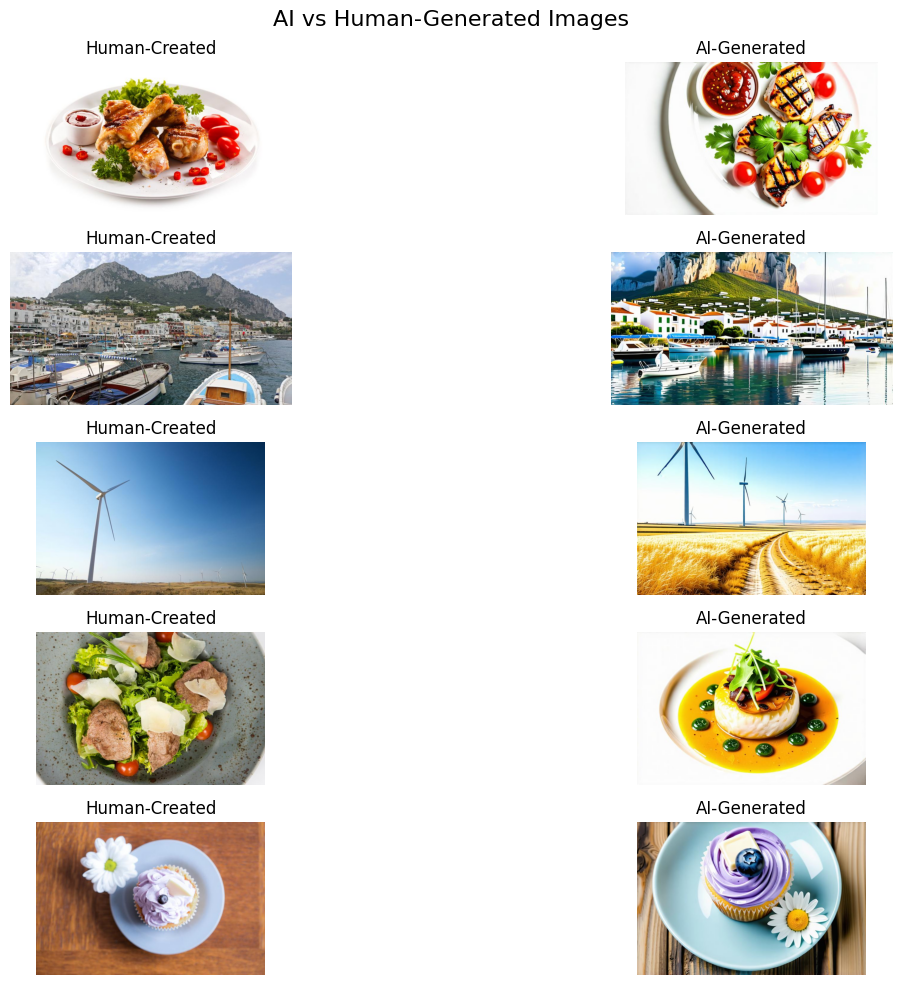

In [ ]:
import cv2

def show_ai_vs_human(df, num_images=5):
    ai_images = df[df["label"] == 1]["file_name"].dropna().sample(num_images, random_state=42).values
    human_images = df[df["label"] == 0]["file_name"].dropna().sample(num_images, random_state=42).values

    plt.figure(figsize=(15, num_images * 2))

    for i, (ai_img_path, human_img_path) in enumerate(zip(ai_images, human_images)):
        # Read AI Image
        ai_img = cv2.imread(ai_img_path)
        human_img = cv2.imread(human_img_path)

        if ai_img is None or human_img is None:
            print(f"Skipping missing images: {ai_img_path} or {human_img_path}")
            continue  # Skip missing images

        ai_img = cv2.cvtColor(ai_img, cv2.COLOR_BGR2RGB)
        human_img = cv2.cvtColor(human_img, cv2.COLOR_BGR2RGB)

        # Show Human Image
        plt.subplot(num_images, 2, i * 2 + 1)
        plt.imshow(human_img)
        plt.axis("off")
        plt.title("Human-Created")

        # Show AI Image
        plt.subplot(num_images, 2, i * 2 + 2)
        plt.imshow(ai_img)
        plt.axis("off")
        plt.title("AI-Generated")

    plt.suptitle("AI vs Human-Generated Images", fontsize=16)
    plt.tight_layout()
    plt.show()

# Display images
show_ai_vs_human(train_df)


##Read the Test Data

In [ ]:
import pandas as pd

image_dataset_path = "/kaggle/input/ai-vs-human-generated-dataset/"

test_df = pd.read_csv(image_dataset_path + "test.csv")
test_df["file_path"] = image_dataset_path + test_df["id"]

test_df.head()


,id,file_path
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...


##Check if test file exist?

In [ ]:
import os

missing_files = test_df[~test_df["file_path"].apply(os.path.exists)]
print(f"Missing test images: {len(missing_files)}")


Missing test images: 0


##Show Test Image

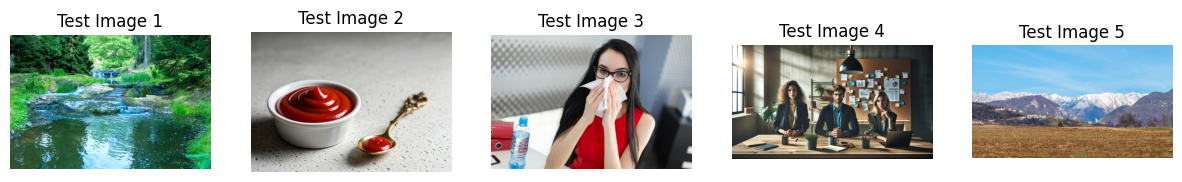

In [ ]:
import matplotlib.pyplot as plt
import cv2

def show_test_images(df, num_images=5):
    sample_images = df.sample(num_images, random_state=42)["file_path"].values

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Test Image {i+1}")

    plt.show()

show_test_images(test_df)



In [ ]:
print(train_df.head())
print(test_df.head())


                                           file_name  label
0  /kaggle/input/ai-vs-human-generated-dataset/tr...      1
1  /kaggle/input/ai-vs-human-generated-dataset/tr...      0
2  /kaggle/input/ai-vs-human-generated-dataset/tr...      1
3  /kaggle/input/ai-vs-human-generated-dataset/tr...      0
4  /kaggle/input/ai-vs-human-generated-dataset/tr...      1
                                                  id  \
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg   
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg   
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg   
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg   
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg   

                                           file_path  
0  /kaggle/input/ai-vs-human-generated-dataset/te...  
1  /kaggle/input/ai-vs-human-generated-dataset/te...  
2  /kaggle/input/ai-vs-human-generated-dataset/te...  
3  /kaggle/input/ai-vs-human-generated-dataset/te...  
4  /kaggle/input/ai-vs-human

##Converting Labels into String

In [ ]:
train_df["label"] = train_df["label"].astype(str)

# ImageDataGenerator with rescaling and validation split

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


In [ ]:
train_generator = data_generator.flow_from_dataframe(
    train_df,
    x_col="file_name",
    y_col="label",
    target_size=(299, 299),
    batch_size=32,
    class_mode="binary",
    subset="training"
)

Found 63960 validated image filenames belonging to 2 classes.


In [ ]:
valid_generator = data_generator.flow_from_dataframe(
    train_df,
    x_col="file_name",
    y_col="label",
    target_size=(299, 299),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)

Found 15990 validated image filenames belonging to 2 classes.


In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

base_model.trainable = False



87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce feature maps to a single vector
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)  # Prevent overfitting
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create final model
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 299, 299,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ cast[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]  

 Total params: 22,983,457 (87.67 MB)

 Trainable params: 1,180,673 (4.50 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

##Compile Model

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer = 'adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])


##Fitting Model

In [ ]:
model_history = model.fit(train_generator, epochs=10, validation_data=valid_generator)


Epoch 1/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 794s 397ms/step - accuracy: 0.8241 - loss: 0.3940 - val_accuracy: 0.8830 - val_loss: 0.2719
Epoch 2/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 435s 217ms/step - accuracy: 0.8692 - loss: 0.3037 - val_accuracy: 0.8870 - val_loss: 0.2679
Epoch 3/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 435s 218ms/step - accuracy: 0.8844 - loss: 0.2711 - val_accuracy: 0.9014 - val_loss: 0.2362
Epoch 4/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 426s 213ms/step - accuracy: 0.8950 - loss: 0.2518 - val_accuracy: 0.8994 - val_loss: 0.2376
Epoch 5/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 432s 208ms/step - accuracy: 0.8982 - loss: 0.2430 - val_accuracy: 0.9011 - val_loss: 0.2401
Epoch 6/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 424s 212ms/step - accuracy: 0.8999 - loss: 0.2347 - val_accuracy: 0.9069 - val_loss: 0.2255
Epoch 7/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 410s 205ms/step - accuracy: 0.9050 - loss: 0.2237 - val_accuracy: 0.9032 - val_loss: 0.2346
Epoch 8/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 422s 211ms/step - ac

In [ ]:
# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(train_generator)

print(f"Accuracy on train data: {train_accuracy:.2%} | Loss: {train_loss:.4f}")

1999/1999 ━━━━━━━━━━━━━━━━━━━━ 355s 178ms/step - accuracy: 0.9344 - loss: 0.1588
Accuracy on train data: 93.48% | Loss: 0.1594


In [ ]:

test_generator = data_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="file_path",
    y_col=None,
    target_size=(299, 299),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 5540 validated image filenames.


In [ ]:
predictions = model.predict(test_generator)

predicted_labels = (predictions > 0.5).astype(int)

174/174 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step


In [ ]:
model.save("ai_vs_human_model.h5")


In [ ]:
from google.colab import files
files.download("ai_vs_human_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!ls -lh ai_vs_human_model.h5

-rw-r--r-- 1 root root 98M Jul 25 10:00 ai_vs_human_model.h5


In [ ]:
!zip model.zip ai_vs_human_model.h5

  adding: ai_vs_human_model.h5 (deflated 12%)


In [ ]:
from google.colab import files
files.download("model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("ai_vs_human_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save('my_model.keras')

In [ ]:
from google.colab import files
files.download("my_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>